In [1]:
import pandas as pd
import numpy as np
import os

df_1 = pd.read_csv("tmdb_5000_movies.csv")
df_2 = pd.read_csv("TMDB_movie_dataset_v11.csv")

df_1 = df_1[['title', 'budget', 'original_language', 'release_date', 'revenue', 'runtime']]
df_2 = df_2[['title', 'genres', 'adult']]

movies_df = pd.merge(df_1, df_2, on="title", how="left")
movies_df = movies_df.drop_duplicates(subset=["title"])

movies_df["is_adult"] = (movies_df["adult"].astype(str).str.strip().str.lower().isin(["true", "1", "yes"])).astype(int)

movies_df.drop(columns=["adult"], inplace=True)

movies_df["release_date"] = pd.to_datetime(movies_df["release_date"], errors="coerce")
movies_df["release_month"] = movies_df["release_date"].dt.month_name()

movies_df["is_success"] = (movies_df["revenue"] >= movies_df["budget"] * 2).astype(int)

print(movies_df)

                                          title     budget original_language  \
0                                        Avatar  237000000                en   
6      Pirates of the Caribbean: At World's End  300000000                en   
7                                       Spectre  245000000                en   
17                        The Dark Knight Rises  250000000                en   
18                                  John Carter  260000000                en   
...                                         ...        ...               ...   
17795                               El Mariachi     220000                es   
17796                                 Newlyweds       9000                en   
17798                 Signed, Sealed, Delivered          0                en   
17799                          Shanghai Calling          0                en   
17800                         My Date with Drew          0                en   

      release_date     revenue  runtime

In [2]:
from sklearn.preprocessing import MultiLabelBinarizer

def clean_genres(x):
    if isinstance(x, str):
        return [g.strip() for g in x.split(',') if g.strip()]
    else:
        return []

movies_df['genres'] = movies_df['genres'].apply(clean_genres)

movies_df['genres'].apply(type).value_counts()
movies_df

,title,budget,original_language,release_date,revenue,runtime,genres,is_adult,release_month,is_success
0,Avatar,237000000,en,2009-12-10,2787965087,162.0,"[Action, Adventure, Fantasy, Science Fiction]",0,December,1
6,Pirates of the Caribbean: At World's End,300000000,en,2007-05-19,961000000,169.0,"[Adventure, Fantasy, Action]",0,May,1
7,Spectre,245000000,en,2015-10-26,880674609,148.0,"[Action, Adventure, Thriller]",0,October,1
17,The Dark Knight Rises,250000000,en,2012-07-16,1084939099,165.0,"[Action, Crime, Drama, Thriller]",0,July,1
18,John Carter,260000000,en,2012-03-07,284139100,132.0,"[Action, Adventure, Science Fiction]",0,March,0
...,...,...,...,...,...,...,...,...,...,...
17795,El Mariachi,220000,es,1992-09-04,2040920,81.0,"[Action, Crime, Thriller]",0,September,1
17796,Newlyweds,9000,en,2011-12-26,0,85.0,"[Comedy, Romance, Drama]",0,December,0
17798,"Signed, Sealed, Delivered",0,en,2013-10-13,0,120.0,"[Comedy, Drama, Romance, TV Movie]",0,October,1
17799,Shanghai Calling,0,en,2012-05-03,0,98.0,"[Romance, Comedy, Drama]",0,May,1


In [3]:
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(movies_df['genres'])

genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)
movies_df = movies_df.join(genres_df)
movies_df = movies_df.drop(columns=['genres'])
movies_df.head()

,title,budget,original_language,release_date,revenue,runtime,is_adult,release_month,is_success,Action,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,Avatar,237000000,en,2009-12-10,2787965087,162.0,0,December,1,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,Pirates of the Caribbean: At World's End,300000000,en,2007-05-19,961000000,169.0,0,May,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Spectre,245000000,en,2015-10-26,880674609,148.0,0,October,1,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
17,The Dark Knight Rises,250000000,en,2012-07-16,1084939099,165.0,0,July,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,John Carter,260000000,en,2012-03-07,284139100,132.0,0,March,0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [4]:
movies_df.insert(loc=8, column='is_english?', value=(movies_df['original_language'] == 'en').astype(int))
movies_df.drop(columns=['original_language'], inplace=True)
movies_df.head()

,title,budget,release_date,revenue,runtime,is_adult,release_month,is_english?,is_success,Action,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,Avatar,237000000,2009-12-10,2787965087,162.0,0,December,1,1,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,Pirates of the Caribbean: At World's End,300000000,2007-05-19,961000000,169.0,0,May,1,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Spectre,245000000,2015-10-26,880674609,148.0,0,October,1,1,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
17,The Dark Knight Rises,250000000,2012-07-16,1084939099,165.0,0,July,1,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,John Carter,260000000,2012-03-07,284139100,132.0,0,March,1,0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [5]:
month_df = pd.get_dummies(movies_df['release_month'], prefix='month')
month_df = month_df.astype(int)
movies_df = movies_df.join(month_df)
movies_df = movies_df.drop(columns=['release_date'])
movies_df.head()

,title,budget,revenue,runtime,is_adult,release_month,is_english?,is_success,Action,Adventure,...,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
0,Avatar,237000000,2787965087,162.0,0,December,1,1,1.0,1.0,...,1,0,0,0,0,0,0,0,0,0
6,Pirates of the Caribbean: At World's End,300000000,961000000,169.0,0,May,1,1,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
7,Spectre,245000000,880674609,148.0,0,October,1,1,1.0,1.0,...,0,0,0,0,0,0,0,0,1,0
17,The Dark Knight Rises,250000000,1084939099,165.0,0,July,1,1,1.0,1.0,...,0,0,0,1,0,0,0,0,0,0
18,John Carter,260000000,284139100,132.0,0,March,1,0,1.0,0.0,...,0,0,0,0,0,1,0,0,0,0


In [6]:
movies_df['big_budget?'] = (movies_df['budget'] >= 100_000_000).astype(int)
movies_df.drop(columns=['budget'], inplace=True)
movies_df.head()

,title,revenue,runtime,is_adult,release_month,is_english?,is_success,Action,Adventure,Animation,...,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September,big_budget?
0,Avatar,2787965087,162.0,0,December,1,1,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,1
6,Pirates of the Caribbean: At World's End,961000000,169.0,0,May,1,1,0.0,0.0,1.0,...,0,0,0,0,0,1,0,0,0,1
7,Spectre,880674609,148.0,0,October,1,1,1.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,1
17,The Dark Knight Rises,1084939099,165.0,0,July,1,1,1.0,1.0,0.0,...,0,0,1,0,0,0,0,0,0,1
18,John Carter,284139100,132.0,0,March,1,0,1.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,1


In [7]:
movies_df['long_runtime?'] = (movies_df['runtime'] >= 120).astype(int)
movies_df.drop(columns=['runtime'], inplace=True)
movies_df.head()

,title,revenue,is_adult,release_month,is_english?,is_success,Action,Adventure,Animation,Comedy,...,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September,big_budget?,long_runtime?
0,Avatar,2787965087,0,December,1,1,1.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,1
6,Pirates of the Caribbean: At World's End,961000000,0,May,1,1,0.0,0.0,1.0,0.0,...,0,0,0,0,1,0,0,0,1,1
7,Spectre,880674609,0,October,1,1,1.0,1.0,0.0,0.0,...,0,0,0,0,0,0,1,0,1,1
17,The Dark Knight Rises,1084939099,0,July,1,1,1.0,1.0,0.0,0.0,...,0,1,0,0,0,0,0,0,1,1
18,John Carter,284139100,0,March,1,0,1.0,0.0,0.0,1.0,...,0,0,0,1,0,0,0,0,1,1


In [8]:
movies_df.drop(columns=['revenue'], inplace=True)

# Drop title column since we only need the movie index, not a string title value

movies_df.drop(columns=['title'], inplace=True)
movies_df.head()

,is_adult,release_month,is_english?,is_success,Action,Adventure,Animation,Comedy,Crime,Documentary,...,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September,big_budget?,long_runtime?
0,0,December,1,1,1.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,1
6,0,May,1,1,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,1,1
7,0,October,1,1,1.0,1.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,1,1
17,0,July,1,1,1.0,1.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,1,1
18,0,March,1,0,1.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,1


In [9]:
columns_order = [
    'month_January', 'month_February', 'month_March', 'month_April', 'month_May', 'month_June', 'month_July', 'month_August',
    'month_September', 'month_October', 'month_November', 'month_December', 'big_budget?', 'long_runtime?', 'is_adult', 'is_english?',
    'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music',
    'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western', 'is_success'
]

movies_df = movies_df[columns_order]

# Drop all NaN values

movies_df = movies_df.dropna()

# Making all the values to integers to make it more uniform

for col in movies_df.columns:
    if movies_df[col].dropna().isin([0.0,1.0]).all():
        movies_df[col] = movies_df[col].astype(int)

movies_df.head()

,month_January,month_February,month_March,month_April,month_May,month_June,month_July,month_August,month_September,month_October,...,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,is_success
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
6,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
17,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
18,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [10]:
# Limits dataset to 1000 records per instructions and randomizes the chosen samples
movies_df = movies_df.sample(frac=1, random_state=42).reset_index(drop=True)
movies_df = movies_df.head(1000)

In [11]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
X_predictor = movies_df[['month_January', 'month_February', 'month_March', 'month_April', 'month_May', 'month_June', 'month_July', 'month_August',
    'month_September', 'month_October', 'month_November', 'month_December', 'big_budget?', 'long_runtime?', 'is_adult', 'is_english?',
    'Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music',
    'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western']]

# All the months were perfectly colinear, resulting in the Singular Matrix error. December was dropped, making it the reference for all the other month coefficients   
X_predictor = X_predictor.drop(columns=['month_December'])

#drops other perfectly correlated pairs, but keeps the first occurrence 
corr = X_predictor.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] == 1)]
X_predictor = X_predictor.drop(columns=to_drop)
Y_dependent = movies_df['is_success']

#removed "constant" columns or columns where every value is identical, which can cause the singular matrix error
constant_cols = [c for c in X_predictor.columns if X_predictor[c].nunique() <= 1]
X_predictor = X_predictor.drop(columns=constant_cols)

X_predictor = sm.add_constant(X_predictor)
moviesuccess_logit = sm.Logit(Y_dependent,X_predictor).fit()
print(moviesuccess_logit.summary())


Optimization terminated successfully.
         Current function value: 0.651413
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:             is_success   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      966
Method:                           MLE   Df Model:                           33
Date:                Thu, 04 Dec 2025   Pseudo R-squ.:                 0.05032
Time:                        21:52:36   Log-Likelihood:                -651.41
converged:                       True   LL-Null:                       -685.93
Covariance Type:            nonrobust   LLR p-value:                 0.0002382
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.6521      0.666      0.979      0.328      -0.654       1.958
month_January 

In [12]:
#2nd methodology: Decision Tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
tree = DecisionTreeClassifier(max_depth=4)
tree.fit(X_predictor, Y_dependent)

y_pred_tree = tree.predict(X_predictor)
print(classification_report(Y_dependent, y_pred_tree))

              precision    recall  f1-score   support

           0       0.61      0.29      0.39       440
           1       0.61      0.85      0.71       560

    accuracy                           0.61      1000
   macro avg       0.61      0.57      0.55      1000
weighted avg       0.61      0.61      0.57      1000



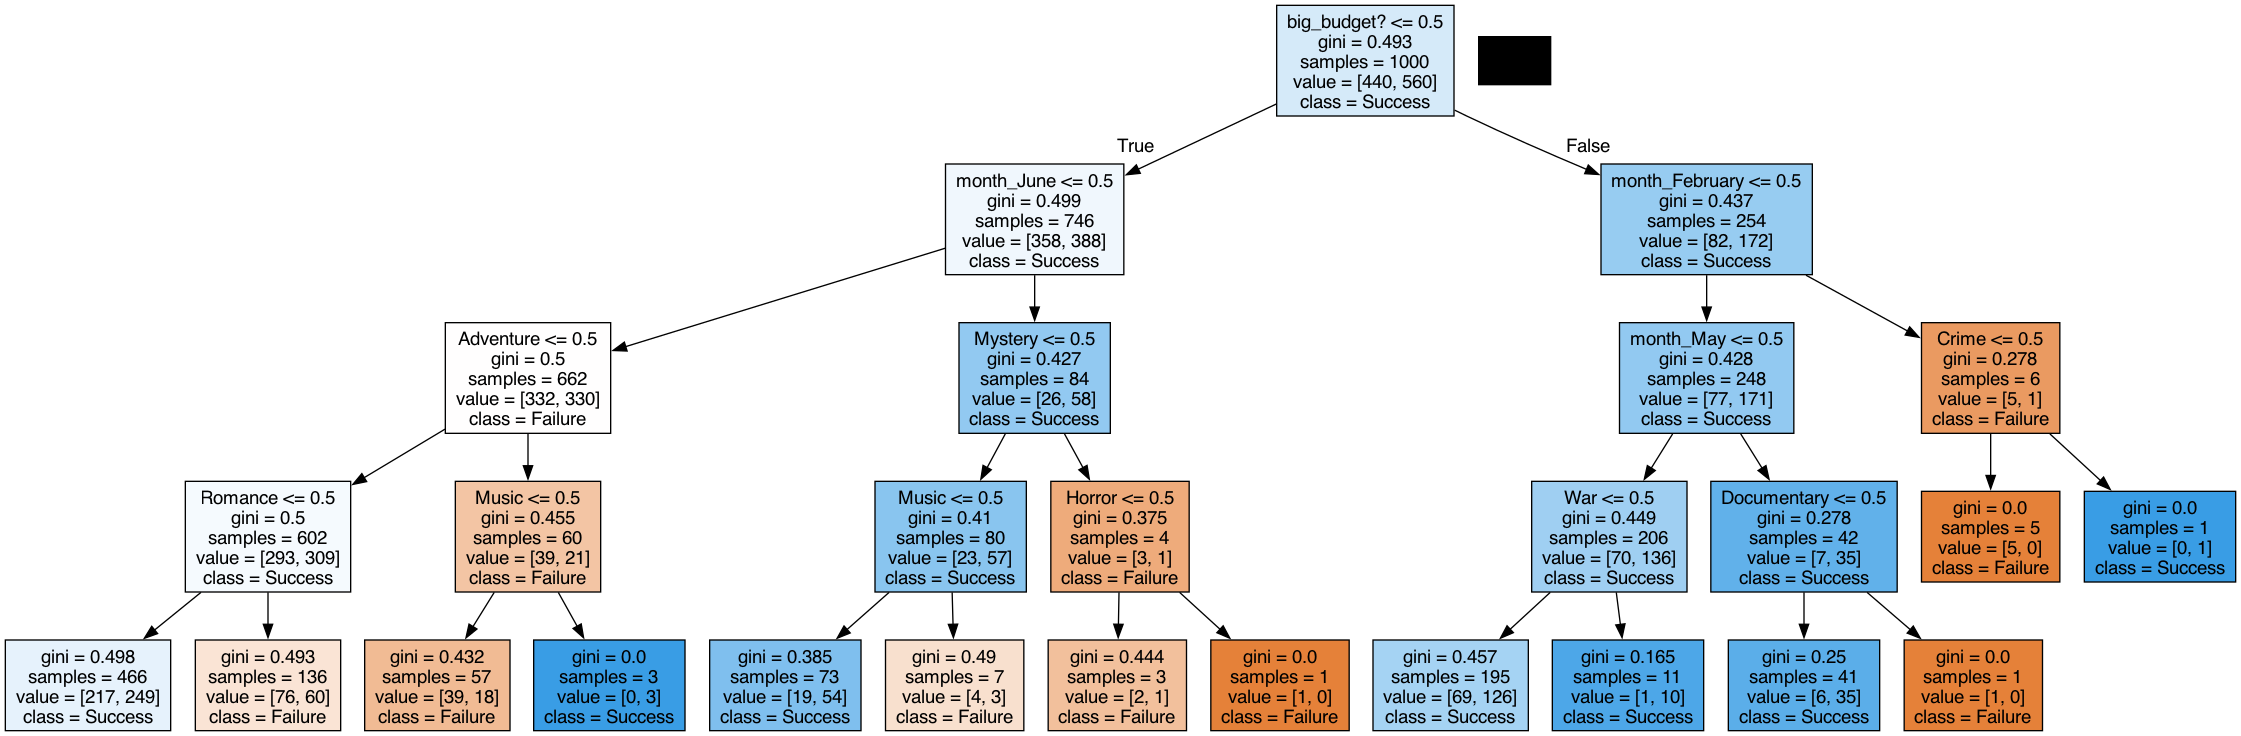

In [13]:
#Visualization of the decision tree
from sklearn.tree import export_graphviz
import pydotplus
import graphviz
from IPython.display import Image
dot_data = export_graphviz(tree, feature_names = X_predictor.columns, class_names = ['Failure','Success'], filled = True, out_file = None)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())